In [51]:
# Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [53]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [55]:
# Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

Using Device: cpu


In [57]:
df=pd.read_csv(r'C:\Users\Doctor Computers\Desktop\Machine Learning 1\Pytorch\fashion-mnist_train.csv')
print(df.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

In [58]:
df.shape

(60000, 785)

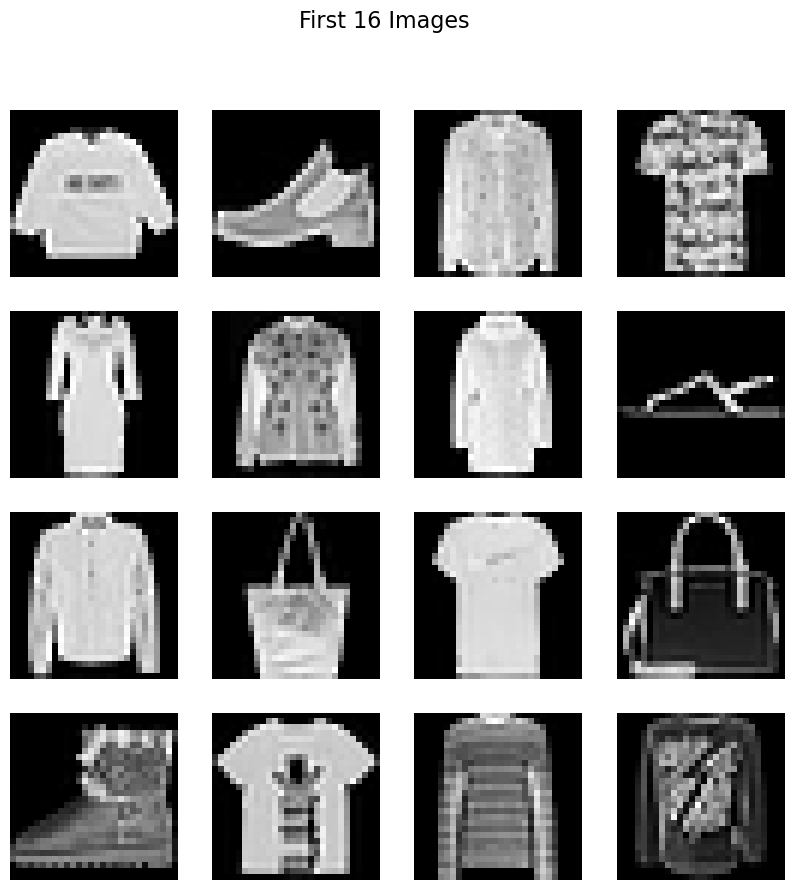

In [61]:
# Create 4x4 grid of first 16 images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

In [63]:
x=df.iloc[:,1:].values
y=df.iloc[:,0].values

In [65]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [66]:
X_train=X_train/255.0
X_test=X_test/255.0

In [71]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1, 1, 28, 28)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [73]:
# Create datasets
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=(device.type == 'cuda'))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=(device.type == 'cuda'))

In [75]:
# Neural Network
class MyNN(nn.Module):
    def __init__(self, input_channels):
        super(MyNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [77]:
# Model, loss, optimizer
model = MyNN(1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

In [79]:
# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_epoch_loss = 0
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()
    
    avg_loss = total_epoch_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 1/10, Loss: 0.5787
Epoch 2/10, Loss: 0.4050
Epoch 3/10, Loss: 0.3482
Epoch 4/10, Loss: 0.3065
Epoch 5/10, Loss: 0.2785
Epoch 6/10, Loss: 0.2622
Epoch 7/10, Loss: 0.2373
Epoch 8/10, Loss: 0.2246
Epoch 9/10, Loss: 0.2172
Epoch 10/10, Loss: 0.2018


In [83]:
# Evaluation
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

accuracy = correct / total
print(f'\nTest Accuracy: {accuracy:.4f}')


Test Accuracy: 0.9183
